In [1]:
from IPython.display import display
import PIL 
import keras
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())


%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.linear_model import LinearRegression

import pandas as pd
import numpy as np
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
df = pd.read_csv('original_full_data.csv', index_col = 0)
mmdf = pd.read_csv('bloomberg_map_index_20200130.csv', index_col = 0)

In [3]:
df.head()

,date,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,...,g16,g32,g64,g128,avg,avg_four,ssd_price,flash_price,option_bit,future_bit
0,1981-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1981-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1981-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1981-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1981-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df.loc[9132 :, :]

In [5]:
len(df)

5051

In [6]:
df.reset_index(inplace = True, drop = True)

In [7]:
# Class generates derived variables & shifting target variable

class Builder:

    def __init__(self, input_df, map_df, target_day):
        self.df = input_df
        self.mdf = map_df
        self.lag_days = [1, 5, 20, 60, 120, 260] # lagging day variation [1day 1week 1month 3month 6month 1year]
        self.target_day = target_day # ex) 1, 260


    # shifting function

    def targeter(self, target_column):
        self.df[target_column] = self.df[target_column].shift(-1*int(self.target_day))

        return self.df
    
    # generating derived columns function : return ex) 20060107/20060101

    def returner(self, target_column):      

        col_name =  []
        # creating new column name
        for i in self.lag_days:
            col_name.append(target_column + str(i))
            
        # appending lagged columns
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = (self.df[target_column] / self.df[target_column].shift(periods = j, axis = 0))-1 # 여기에 1을 뺀걸 추가하면 되는거아닌가? 1.얼만에서 1이 빠진거니까

        return self.df 

    # generating derived function : minus ex) 20060107 - 20060101
    
    def differ(self, target_column):

        col_name = []
        for i in self.lag_days:
            col_name.append(target_column + str(i))
        for i, j in enumerate(self.lag_days):
            self.df[locals()['col_name'][i]] = self.df[target_column] - self.df[target_column].shift(periods = j, axis = 0)
        return self.df

    # generating derived function : volume * close  -> convert to return 

    def producter(self, target_column):

        col_name = (str(target_column).split('_'))[0]       
        self.df[locals()['col_name'] + '_product'] = self.df[col_name + '_volume'] * self.df[col_name + '_close'] # j volume과 j close를 곱해서 

        return self.df
    
    # executing functions
    
    def execution(self):
        for i, j in enumerate(self.mdf['ticker']): # mdf에서 ticker 확인
            if j in self.df.columns:
                if self.mdf.loc[i, :][1] == 'product':  # key값이 product인 경우
                    self.producter(j)
                    col = str(j).split('_')[0]
                    self.df[col + '_product'] = self.df[col + '_product'] / self.df[col + '_product'].shift(1)
                    
                elif self.mdf.loc[i, :][1] == 'minus': # key값이 minus인 경우
                    self.differ(j)

                elif self.mdf.loc[i, :][1] == 'change': # key값이 change인 경우
                    self.returner(j)


                elif self.mdf.loc[i, :][1] == 'target': # key값이 target인 경우 (현재 KRXsemiconductor_change)
                    self.targeter(j)

                else:
                    pass
            else:
                pass
                            
        return self.df


    # side : creating auto correlation graph function

    def acf_cal(self, target):
        data = pd.DataFrame(self.df[target])
        data = data.interpolate(method = 'cubic', limit_area = 'inside').fillna(method = 'ffill').fillna(method = 'bfill')
        acf = sm.tsa.acf(data)      
        plt.stem(acf)
        plt.show()

In [8]:
# metric 구성

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

class CustomMetric():

    def __init__(self, pred, real):
            self.pred = pred
            self.real = real
            self.thr25 = np.percentile(self.real, 25)
            self.thr75 = np.percentile(self.real, 75)
            self.df = pd.DataFrame({'pred' : self.pred, 'real' : self.real})
        
    def issame(self, data1, data2):
        if data1 > 0 and data2 > 0 : 
            return 'T'
        elif data1 > 0 and data2 < 0 :
            return 'F'
        elif data1 < 0 and data2 > 0 :
            return 'F'
        elif data1 < 0 and data2 < 0 :
            return 'T'
        elif data1 == 0 or data2 == 0 :
            return 0
        else :
            return 'notcal'

    def getouter(self, data1, data2): #quantile_25 = np.percentile(values, 25)

        if data1 > 0 and data2 >= self.thr75 :
            return 'T'
        elif data1 < 0 and data2 <= self.thr25 :
            return 'T'
        elif data1 >= 0 and data2 <= self.thr25 :
            return 'F'
        elif data1 <= 0 and data2 >= self.thr75: 
            return 'F'
        else:
            return 'notcal'
        
    def makedf(self):
        self.df['TF'] = self.df.apply(lambda x : self.issame(x['pred'], x['real']), axis = 1)
        self.df['thrTF'] = self.df.apply(lambda x : self.getouter(x['pred'], x['real']), axis = 1)
        
        return self.df
        
    def execution(self):
        mdf = pd.DataFrame()
        mdf['CORR'] = [self.df['real'].corr(self.df['pred'], method = 'pearson')]
        mdf['R2'] = ["{0:0.4f}".format(r2_score(self.df['real'], self.df['pred']))]
        mdf['MAE'] = ["{0:0.4f}".format(mean_absolute_error(self.df['pred'], self.df['real']))]
        mdf['RMSE'] = ["{0:0.4f}".format(np.sqrt(mean_squared_error(self.df['pred'], self.df['real'])))]
        mdf['ACR'] = [sum(self.df['TF'] == 'T')/len(self.df['TF'])]
        
        mdf['threshACR'] = [sum(self.df['thrTF'] == 'T') / sum(self.df['thrTF'] != 'notcal')]
        
        return mdf     

In [9]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace = True)

In [10]:
# fillna cubic -> ffill -> bfill

df = df.interpolate(method = 'cubic', limit_area = 'inside')
df = df.fillna(method = 'ffill')
df = df.fillna(method = 'bfill')

In [11]:
df.isna().sum().sum()

0

In [12]:
cla = Builder(df, mmdf, 260)

In [13]:
cla.execution()

,GDPCQOQIndex,GDPCYOYIndex,GDPCTOT%Index,GPDITOC%Index,GPGSTOC%Index,RGCDCIPIIndex,GDPCUR$Index,GDPCURYIndex,GDPPIQQIndex,GDPCPCECIndex,...,Philadelphia_product,QCOM_product,SamsungElectronics_product,ShinEtsuChemical_product,Siltronic_product,SKhynix_product,Sumco_product,TokyoElectron_product,TSMC_product,UMC_product
date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.000000,1.000000,0.862009,1.000000,1.000000,1.048766,1.000000,1.000000,1.000000,1.000000
2006-01-04,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,0.967923,1.097724,2.307115,1.000000,1.000000,1.549763,1.000000,1.000000,0.788606,0.581332
2006-01-05,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.168471,0.642743,0.878133,1.000000,1.000000,0.913503,1.000000,4.149537,0.835657,2.780952
2006-01-06,5.4,3.4,4.5,6.1,5.2,102.7,13603.93,6.6,2.8,2.3,...,1.047620,2.572150,0.504080,1.000000,1.000000,0.596882,1.000000,1.117321,1.553101,1.545230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.954025,1.223596,-7.016632,1.443049,0.882592,0.724875,0.591650,1.185079,0.728242,8.957344
2019-10-28,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,0.988696,0.869484,3.268112,0.911087,0.984864,0.598464,0.436636,1.103782,1.596400,-4.887075
2019-10-29,1.9,2.0,2.9,-1.5,2.0,69.0,21525.82,3.7,1.7,2.2,...,1.023202,0.493114,1.174228,0.410159,1.089446,0.832789,1.231150,1.131356,1.864625,2.523049


In [14]:
df = cla.df.fillna(method = 'ffill').fillna(method = 'bfill')

In [15]:
df = df[0:4791]

In [16]:
df.reset_index(inplace = True)

In [17]:
len(df)

4791

In [18]:
len(df.columns)

1139

In [19]:
# 전 변수 쓰는 것으로 . 그래서 feaature는 그대로 
feature_considered = ['HPE_close', 'KOBPTBIndex260', 'MAPMINDXIndex1', 'KOBPFINIndex5', 'MAPMINDXIndex60', 'MWINCHNGIndex', 'HPE_product', 'SKLICONTIndex120', 'Aspeed_volume', 'KOVMDOMSIndex120', 'KOBPCAIndex1', 'SKLICIIndex1', 'KOGFBALIndex', 'CPIXYOYIndex', 'SKLIWNRSIndex60', 'INJCJCIndex60', 'NAPMNEWOIndex1', 'Aspeed_change', 'TSMC_change', 'SKBSICIndex120', 'OEKRN022Index60', 'SKLISVCIIndex60', 'Philadelphia_product', 'QCOM_volume', 'SKLILAPIndex60', 'KOVMDOMSIndex1', 'CICRTOTIndex5', 'KODIBALIndex260', 'OUTFGAFIndex60', 'SAARTOTLIndex20', 'SAARDTOTIndex20', 'FRNTTOTLIndex1', 'SKLISVCIIndex1', 'TokyoElectron_volume', 'KOBONTLIndex1', 'KOBPCBIndex20', 'SKLISHPPIndex20', 'KOBPCBIndex5', 'Micron_change', 'USD_KRW_change', 'SKBSICSAIndex20', 'SamsungElectronics_change', 'COMFCOMFIndex20', 'ShinEtsuChemical_change', 'option_bit', 'tangible_asset_increase_rate', 'Amazon_product', 'TSMC_volume', 'CPMINEXOIndex', 'FDIDSGMOIndex', 'LEIAVGWIndex5', 'LEIBPIndex20', 'OEKRN022Index', 'Microsoft_volume', 'SKLILCIndex260', 'KOIPMCIndex5', 'future_bit', 'KOWDRIndex20', 'ShinEtsuChemical_product', 'MAPMINDXIndex5', 'OUTFGAFIndex20', 'CPMINORDIndex20', 'OUTFGAFIndex1', 'SAARDTOTIndex120', 'KOCPIMOMIndex', 'MediaTek_change', 'Siltronic_product', 'APPLE_product', 'INJCJCIndex1', 'CONSSENTIndex20', 'NAPMPMIIndex1', 'LamResearch_volume', 'FRNTTNETIndex20', 'LEILCIIndex120', 'Microsoft_product', 'KOIPMSIndex5', 'Intel_product', 'Nvidia_product', 'KOHEUINYIndex', 'LEIACEIndex120', 'LEIMNOIndex1', 'AWHTOTLIndex120', 'KOFETOTIndex60', 'SKCIMOMIndex', 'KOBPCBIndex1', 'KOBSMCIndex120', 'KOIPMSIndex60', 'NAPMPMIIndex20', 'NAPMPMIIndex5', 'USTBIMPIndex', 'NAPMPMIIndex60', 'TokyoElectron_change', 'KOIMTOTIndex120', 'CFNAIIndex5', 'KOCLLNSIndex5', 'KWCDCCurncy60', 'AWHTOTLIndex60', 'FDIDFDMOIndex', 'AppliedMaterials_volume', 'KODIBALIndex', 'CPMINEXOIndex60', 'KORSTIndex120', 'SamsungElectronics_close', 'CHPMINDXIndex1', 'KODIBALIndex120', 'SKhynix_volume', 'USTBEXPIndex120', 'SKLISVCIIndex120', 'MAPMINDXIndex20', 'AMD_product', 'CNCILIIndex20', 'Amazon_volume', 'KOIPMCYIndex', 'MPMIUSCAIndex', 'MPMIJPCAIndex', 'MPMIUSMAIndex', 'MPMIUSSAIndex', 'MPMIJPMAIndex', 'MPMIKRMAIndex', 'MPMIJPSAIndex', 'Dell_close', 'Dell_volume', 'Dell_change', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'MPMIUSCAIndex1', 'MPMIUSCAIndex5', 'MPMIUSCAIndex20', 'MPMIUSCAIndex60', 'MPMIUSCAIndex120', 'MPMIUSCAIndex260', 'MPMIUSMAIndex1', 'MPMIUSMAIndex5', 'MPMIUSMAIndex20', 'MPMIUSMAIndex60', 'MPMIUSMAIndex120', 'MPMIUSMAIndex260', 'MPMIUSSAIndex1', 'MPMIUSSAIndex5', 'MPMIUSSAIndex20', 'MPMIUSSAIndex60', 'MPMIUSSAIndex120', 'MPMIUSSAIndex260', 'MPMIJPCAIndex1', 'MPMIJPCAIndex5', 'MPMIJPCAIndex20', 'MPMIJPCAIndex60', 'MPMIJPCAIndex120', 'MPMIJPCAIndex260', 'MPMIJPMAIndex1', 'MPMIJPMAIndex5', 'MPMIJPMAIndex20', 'MPMIJPMAIndex60', 'MPMIJPMAIndex120', 'MPMIJPMAIndex260', 'MPMIJPSAIndex1', 'MPMIJPSAIndex5', 'MPMIJPSAIndex20', 'MPMIJPSAIndex60', 'MPMIJPSAIndex120', 'MPMIJPSAIndex260', 'Dell_product', 'KOVMTOTSIndex1', 'KOVMEXPSIndex1', 'KOLPIIndex', 'CPICHNGIndex', 'LEIBPIndex1', 'CPMINORDIndex120', 'LEIMNOIndex60', 'KOEXTOTIndex1', 'psr']
target_considered = ['KRXsemiconductor_change']

In [20]:
features = df[feature_considered]
targets = df[target_considered]

In [56]:
#features = df.drop(['date', 'KRXsemiconductor_change'], axis = 1)

In [21]:
features.index = df['date']
targets.index = df['date']

In [22]:
len(features.columns)

173

In [58]:
#features.drop(['KRXsemiconductor_close', 'KRXsemiconductor_volume','SamsungElectronics_product'], axis =1 , inplace = True)

In [26]:
col_name = features.columns
dataset = StandardScaler().fit_transform(features)# Standard Scaler , drop Samsung electronics product
dataset = pd.DataFrame(dataset, columns = col_name)

In [27]:
X_data = dataset

In [28]:
y_target = targets

In [29]:
len(X_data), len(y_target)

(4791, 4791)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, shuffle = False)

In [31]:
X_train = X_train.values

In [32]:
y_train = y_train.values

In [33]:
X_test = X_test.values

In [34]:
y_test = y_test.values

In [35]:
dataset.shape

(4791, 173)

In [36]:
X_train.shape

(3832, 173)

In [71]:
'''
## Feature Selection Code
# Forward stepwise feature selection
# linear model 기준으로 유효 feature 뽑기. 돌리지 않아도 되는 코드

np.random.seed(0)

feature_name = list(X_train.columns)
feature_selected = []
score = []

for i in range(X_train.shape[1]):
    score_temp_list = np.zeros(len(feature_name))
    for j in range(len(feature_name)):
        temp = feature_selected.copy() 
        temp.append(feature_name[j])
        x_temp = X_train[temp]
        lr_temp = LinearRegression() 
        lr_temp.fit(x_temp, y_train)
        predict_temp = lr_temp.predict(X_test[temp])
        r2_temp = r2_score(y_test, predict_temp)
        score_temp = r2_temp
        score_temp_list[j] = score_temp 
        
    temp = feature_name[score_temp_list.argmax()]
    feature_selected.append(temp)
    feature_name.remove(temp)
    score.append(score_temp_list.max())
    print("%02d Selected: "%i, feature_selected)
    print("%02d Score : "%i, np.round(10000*np.array(score))/10000)
        
# finally selected features
feature_selected_final = feature_selected[:(np.array(score).argmax() + 1)]

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-71-dcc4a0f6e932>, line 33)

In [ ]:
# 125까지
#['HPE_close', 'KOBPTBIndex260', 'MAPMINDXIndex1', 'KOBPFINIndex5', 'MAPMINDXIndex60', 'MWINCHNGIndex', 'HPE_product', 'SKLICONTIndex120', 'Aspeed_volume', 'KOVMDOMSIndex120', 'KOBPCAIndex1', 'SKLICIIndex1', 'KOGFBALIndex', 'CPIXYOYIndex', 'SKLIWNRSIndex60', 'INJCJCIndex60', 'NAPMNEWOIndex1', 'Aspeed_change', 'TSMC_change', 'SKBSICIndex120', 'OEKRN022Index60', 'SKLISVCIIndex60', 'Philadelphia_product', 'QCOM_volume', 'SKLILAPIndex60', 'KOVMDOMSIndex1', 'CICRTOTIndex5', 'KODIBALIndex260', 'OUTFGAFIndex60', 'SAARTOTLIndex20', 'SAARDTOTIndex20', 'FRNTTOTLIndex1', 'SKLISVCIIndex1', 'TokyoElectron_volume', 'KOBONTLIndex1', 'KOBPCBIndex20', 'SKLISHPPIndex20', 'KOBPCBIndex5', 'Micron_change', 'USD_KRW_change', 'SKBSICSAIndex20', 'SamsungElectronics_change', 'COMFCOMFIndex20', 'ShinEtsuChemical_change', 'option_bit', 'tangible_asset_increase_rate', 'Amazon_product', 'TSMC_volume', 'CPMINEXOIndex', 'FDIDSGMOIndex', 'LEIAVGWIndex5', 'LEIBPIndex20', 'OEKRN022Index', 'Microsoft_volume', 'SKLILCIndex260', 'KOIPMCIndex5', 'future_bit', 'KOWDRIndex20', 'ShinEtsuChemical_product', 'MAPMINDXIndex5', 'OUTFGAFIndex20', 'CPMINORDIndex20', 'OUTFGAFIndex1', 'SAARDTOTIndex120', 'KOCPIMOMIndex', 'MediaTek_change', 'Siltronic_product', 'APPLE_product', 'INJCJCIndex1', 'CONSSENTIndex20', 'NAPMPMIIndex1', 'LamResearch_volume', 'FRNTTNETIndex20', 'LEILCIIndex120', 'Microsoft_product', 'KOIPMSIndex5', 'Intel_product', 'Nvidia_product', 'KOHEUINYIndex', 'LEIACEIndex120', 'LEIMNOIndex1', 'AWHTOTLIndex120', 'KOFETOTIndex60', 'SKCIMOMIndex', 'KOBPCBIndex1', 'KOBSMCIndex120', 'KOIPMSIndex60', 'NAPMPMIIndex20', 'NAPMPMIIndex5', 'USTBIMPIndex', 'NAPMPMIIndex60', 'TokyoElectron_change', 'KOIMTOTIndex120', 'CFNAIIndex5', 'KOCLLNSIndex5', 'KWCDCCurncy60', 'AWHTOTLIndex60', 'FDIDFDMOIndex', 'AppliedMaterials_volume', 'KODIBALIndex', 'CPMINEXOIndex60', 'KORSTIndex120', 'SamsungElectronics_close', 'CHPMINDXIndex1', 'KODIBALIndex120', 'SKhynix_volume', 'USTBEXPIndex120', 'SKLISVCIIndex120', 'MAPMINDXIndex20', 'AMD_product', 'CNCILIIndex20', 'Amazon_volume', 'KOIPMCYIndex', 'MPMIUSCAIndex', 'MPMIJPCAIndex', 'MPMIUSMAIndex', 'MPMIUSSAIndex', 'MPMIJPMAIndex', 'MPMIKRMAIndex', 'MPMIJPSAIndex', 'Dell_close', 'Dell_volume', 'Dell_change', 'EUR_KRW_volume', 'JPY_KRW_volume', 'USDollarIndex_volume', 'USD_KRW_volume', 'MPMIUSCAIndex1', 'MPMIUSCAIndex5', 'MPMIUSCAIndex20', 'MPMIUSCAIndex60', 'MPMIUSCAIndex120', 'MPMIUSCAIndex260', 'MPMIUSMAIndex1', 'MPMIUSMAIndex5', 'MPMIUSMAIndex20', 'MPMIUSMAIndex60', 'MPMIUSMAIndex120', 'MPMIUSMAIndex260', 'MPMIUSSAIndex1', 'MPMIUSSAIndex5', 'MPMIUSSAIndex20', 'MPMIUSSAIndex60', 'MPMIUSSAIndex120', 'MPMIUSSAIndex260', 'MPMIJPCAIndex1', 'MPMIJPCAIndex5', 'MPMIJPCAIndex20', 'MPMIJPCAIndex60', 'MPMIJPCAIndex120', 'MPMIJPCAIndex260', 'MPMIJPMAIndex1', 'MPMIJPMAIndex5', 'MPMIJPMAIndex20', 'MPMIJPMAIndex60', 'MPMIJPMAIndex120', 'MPMIJPMAIndex260', 'MPMIJPSAIndex1', 'MPMIJPSAIndex5', 'MPMIJPSAIndex20', 'MPMIJPSAIndex60', 'MPMIJPSAIndex120', 'MPMIJPSAIndex260', 'Dell_product', 'KOVMTOTSIndex1', 'KOVMEXPSIndex1', 'KOLPIIndex', 'CPICHNGIndex', 'LEIBPIndex1', 'CPMINORDIndex120', 'LEIMNOIndex60', 'KOEXTOTIndex1', 'psr']

In [37]:
X_train_t = X_train.reshape(X_train.shape[0], 173, 1)

In [38]:
X_train_t.shape

(3832, 173, 1)

In [39]:
X_test_t = X_test.reshape(X_test.shape[0], 173, 1)

In [40]:
X_train_t.shape, X_test_t.shape

((3832, 173, 1), (959, 173, 1))

In [41]:
# rmse custorm metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [42]:
# Begas Custom Loss Function
def customLoss(y_true, y_pred):
    mean_true = tf.math.reduce_mean(y_true)
    mean_pred = tf.math.reduce_mean(y_pred)
    
    std_true = tf.math.reduce_std(y_true)
    std_pred = tf.math.reduce_std(y_pred)
    
    up = tf.reduce_mean(tf.math.multiply((y_true-mean_true), (y_pred-mean_pred)))
    down = std_true * std_pred
    corr = 1.0-tf.compat.v1.where(tf.math.is_nan(up/down),0.0,up/down)
    
    
    meanerr = tf.math.sqrt(tf.math.square(mean_true - mean_pred))
    mserr = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_true-y_pred)))
    signerr = 1-tf.math.reduce_mean(tf.math.multiply(tf.math.sign(y_true), tf.math.sign(y_pred)))
    
    return mserr + corr/2 + signerr/2

In [62]:
K.clear_session()

# using /gpu:0
with tf.device('/gpu:0'):
    
    # model build
    model = Sequential(name = 'KRXSemicondoctor_regressor')
    model.add(GRU(64, input_shape = (173, 1), return_sequences = True, name = 'input'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    model.add(GRU(64, return_sequences = True, name = 'gru_cell_0'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())
    
    model.add(GRU(32, return_sequences = False, name = 'gru_cell_1'))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    model.add(Dense(1, activation = 'linear', name = 'output',
                   kernel_regularizer=keras.regularizers.l2(l=0.3)))
                   #kernel_initializer=tf.keras.initializers.Orthogonal(seed=925))) 

    #rmsprop = optimizers.rmsprop(lr = 0.01)
    adam = optimizers.Adam(lr = 0.001)
    
    # compile model
    model.compile(loss = customLoss,
                  optimizer=adam,
                  metrics=['mse'])
    
    # early stopping
    early_stop = EarlyStopping(monitor='mse', patience=20, verbose=1)
    
    # model check
    model.summary()
    
    h = model.fit(X_train_t, y_train, epochs=1000,
          batch_size=100, verbose=1, callbacks=[early_stop])

Model: "KRXSemicondoctor_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (GRU)                  (None, 173, 64)           12672     
_________________________________________________________________
dropout_1 (Dropout)          (None, 173, 64)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 173, 64)           256       
_________________________________________________________________
gru_cell_0 (GRU)             (None, 173, 64)           24768     
_________________________________________________________________
dropout_2 (Dropout)          (None, 173, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 173, 64)           256       
_________________________________________________________________
gru_cell_1 (GRU)             (None, 32) 

In [63]:
y_pred = model.predict(X_test_t)
x_pred = model.predict(X_train_t)

In [64]:
len(x_pred)

3832

In [65]:
y_pred = np.reshape(y_pred, (959))
y_test = np.reshape(y_test, (959))
x_pred = np.reshape(x_pred, (3832))
y_trai = np.reshape(y_train, (3832))

In [66]:
metr = CustomMetric(x_pred, y_trai)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.622926,0.3721,1.2079,1.7130,0.680846,0.776275


In [67]:
metr = CustomMetric(y_pred, y_test)
metr.makedf()
metr.execution()

,CORR,R2,MAE,RMSE,ACR,threshACR
0,0.054171,-0.1806,1.6648,2.1686,0.506778,0.522917


In [73]:
len(x_pred), len(y_pred)

(3832, 959)

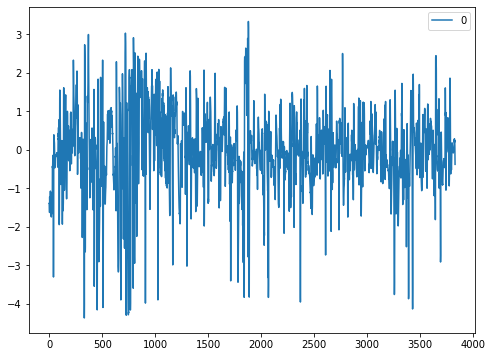

In [68]:
pd.DataFrame(x_pred).plot()

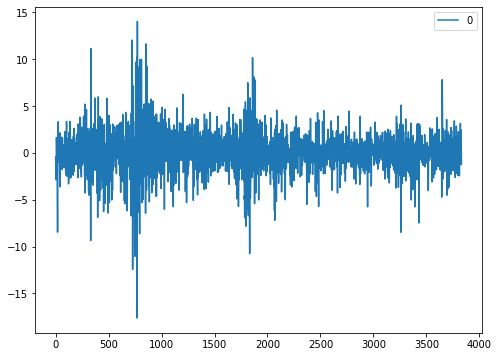

In [69]:
pd.DataFrame(y_train).plot()

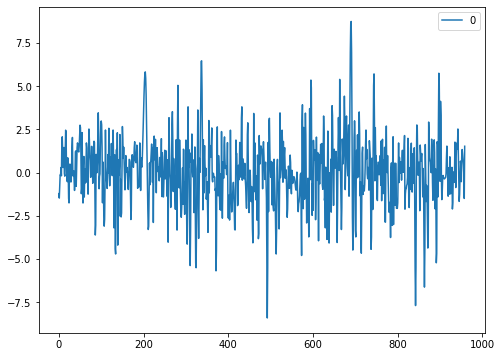

In [70]:
pd.DataFrame(y_test).plot()

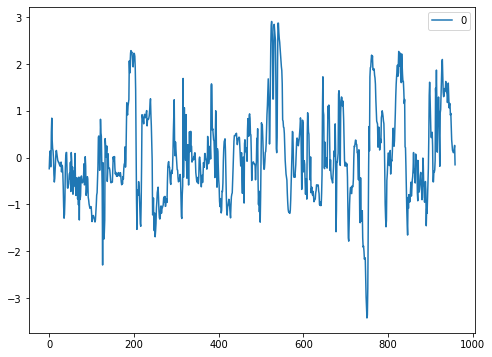

In [71]:
pd.DataFrame(y_pred).plot()

In [ ]:
#mse = h.history['mse']
#val_mse = h.history['val_mse']
loss = h.history['loss']
#val_loss = h.history['val_loss']

epochs = range(1, len(loss) + 1)

#plt.plot(epochs, mse, 'bo', label = 'Training mse')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation mse')
#plt.title('mse')
#plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training loss')
#plt.plot(epohcs, val_mse, 'b', label = 'Validation loss')
plt.title('loss')
plt.legend()

plt.show()

In [ ]:
a_axis = np.arange(0, len(y_train))
b_axis = np.arange(len(y_train), len(y_train) + len(y_pred))

plt.figure(figsize=(10,6))
plt.plot(a_axis, y_train.reshape(4040,), '-')
plt.plot(b_axis, y_pred.reshape(1011,), '-', color='red', label='Predicted')
plt.plot(b_axis, y_test.reshape(1011,), '-', color='green', alpha=0.2, label='Actual')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

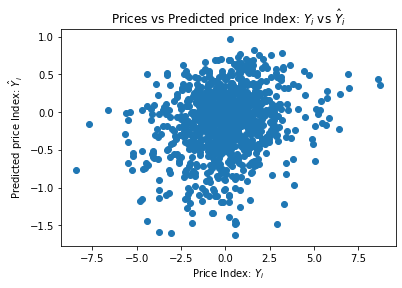

In [279]:
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")